Import thư viện và đọc dữ liệu 

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Load data
train_df = pd.read_csv("../Dataset/712/train.csv", parse_dates=["date"])
valid_df = pd.read_csv("../Dataset/712/validation.csv", parse_dates=["date"])
test_df = pd.read_csv("../Dataset/712/test.csv", parse_dates=["date"])


Lựa chọn đặc trưng và target 

In [2]:
features = ['tickets_sold', 'tickets_out', 'show_time', 'occu_perc',
            'ticket_price', 'ticket_use', 'capacity', 'month', 'quarter', 'day', 'year']
target = 'total_sales'

X_train = train_df[features].values
y_train = train_df[target].values

X_valid = valid_df[features].values
y_valid = valid_df[target].values

X_test = test_df[features].values
y_test = test_df[target].values

Chuẩn hóa dữ liệu 

In [3]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train = scaler_X.fit_transform(X_train)
y_train = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()

X_valid = scaler_X.transform(X_valid)
y_valid = scaler_y.transform(y_valid.reshape(-1, 1)).flatten()

X_test = scaler_X.transform(X_test)
y_test = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

Dataset & Dataloader

In [4]:
class SalesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = SalesDataset(X_train, y_train)
valid_dataset = SalesDataset(X_valid, y_valid)
test_dataset = SalesDataset(X_test, y_test)

Mô hình Transformer 

In [5]:
class TransformerRegressor(nn.Module):
    def __init__(self, input_dim, d_model=64, nhead=4, num_layers=2):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.output = nn.Linear(d_model, 1)

    def forward(self, x):
        # x shape: (batch, feature) → (seq_len=1, batch, d_model)
        x = self.input_proj(x).unsqueeze(0)
        x = self.transformer(x)
        x = self.output(x).squeeze(0)
        return x.squeeze(1)

Huấn luyện mô hình 

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TransformerRegressor(input_dim=len(features)).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64)

train_losses, valid_losses = [], []

for epoch in range(30):
    model.train()
    running_loss = 0
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        preds = model(x_batch)
        loss = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x_batch, y_batch in valid_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            preds = model(x_batch)
            loss = criterion(preds, y_batch)
            val_loss += loss.item()
    val_loss /= len(valid_loader)
    valid_losses.append(val_loss)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Valid Loss: {val_loss:.4f}")


c:\Users\Tran Thi Kieu Oanh\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1, Train Loss: 0.2818, Valid Loss: 0.3093
Epoch 2, Train Loss: 0.1991, Valid Loss: 0.2613
Epoch 3, Train Loss: 0.1641, Valid Loss: 0.2491
Epoch 4, Train Loss: 0.1363, Valid Loss: 0.1986
Epoch 5, Train Loss: 0.1166, Valid Loss: 0.1748
Epoch 6, Train Loss: 0.0973, Valid Loss: 0.1635
Epoch 7, Train Loss: 0.0893, Valid Loss: 0.1427
Epoch 8, Train Loss: 0.0784, Valid Loss: 0.1290
Epoch 9, Train Loss: 0.0700, Valid Loss: 0.1224
Epoch 10, Train Loss: 0.0628, Valid Loss: 0.1292
Epoch 11, Train Loss: 0.0577, Valid Loss: 0.1058
Epoch 12, Train Loss: 0.0466, Valid Loss: 0.0909
Epoch 13, Train Loss: 0.0461, Valid Loss: 0.1061
Epoch 14, Train Loss: 0.0448, Valid Loss: 0.0877
Epoch 15, Train Loss: 0.0379, Valid Loss: 0.0907
Epoch 16, Train Loss: 0.0345, Valid Loss: 0.0751
Epoch 17, Train Loss: 0.0339, Valid Loss: 0.0821
Epoch 18, Train Loss: 0.0355, Valid Loss: 0.0789
Epoch 19, Train Loss: 0.0276, Valid Loss: 0.0789
Epoch 20, Train Loss: 0.0265, Valid Loss: 0.0934
Epoch 21, Train Loss: 0.0288,

Đánh giá mô hình 

In [7]:
def evaluate(model, dataset, scaler_y, name="Test"):
    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for x, y in DataLoader(dataset, batch_size=64):
            x = x.to(device)
            output = model(x).cpu().numpy()
            preds.extend(output.tolist())
            targets.extend(y.numpy().tolist())

    # Inverse scaling
    preds = scaler_y.inverse_transform(np.array(preds).reshape(-1, 1)).flatten()
    targets = scaler_y.inverse_transform(np.array(targets).reshape(-1, 1)).flatten()

    mae = mean_absolute_error(targets, preds)
    mse = mean_squared_error(targets, preds)
    r2 = r2_score(targets, preds)

    print(f"{name} - MAE: {mae:.2f}, MSE: {mse:.2f}, R2: {r2:.2f}")

    return preds, targets

test_preds, test_targets = evaluate(model, test_dataset, scaler_y)

Test - MAE: 4264219.55, MSE: 20399995727736.96, R2: 0.98


So sánh doanh thu thực tế với dự đoán 

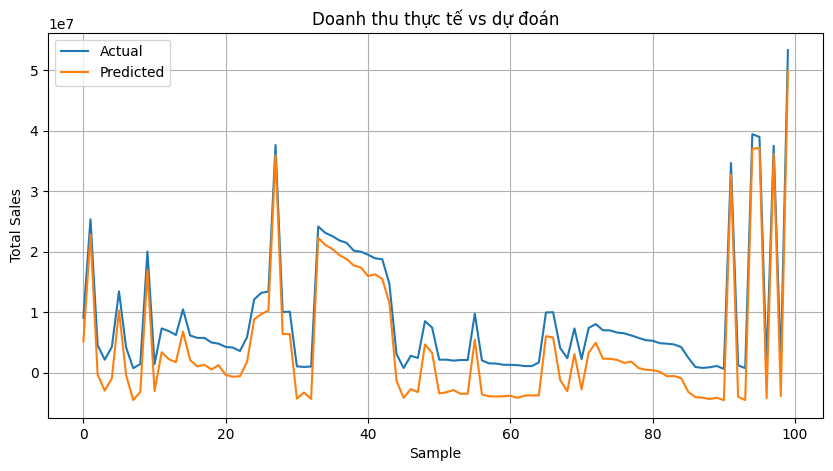

In [8]:
plt.figure(figsize=(10,5))
plt.plot(test_targets[:100], label='Actual')
plt.plot(test_preds[:100], label='Predicted')
plt.legend()
plt.title('Doanh thu thực tế vs dự đoán')
plt.xlabel('Sample')
plt.ylabel('Total Sales')
plt.grid(True)
plt.show()

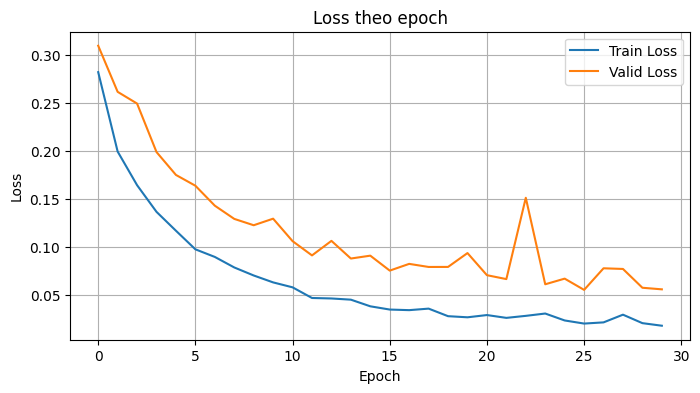

In [9]:
plt.figure(figsize=(8,4))
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss')
plt.legend()
plt.title('Loss theo epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

Dự đoán doanh thu trong 30 ngày tiếp theo 

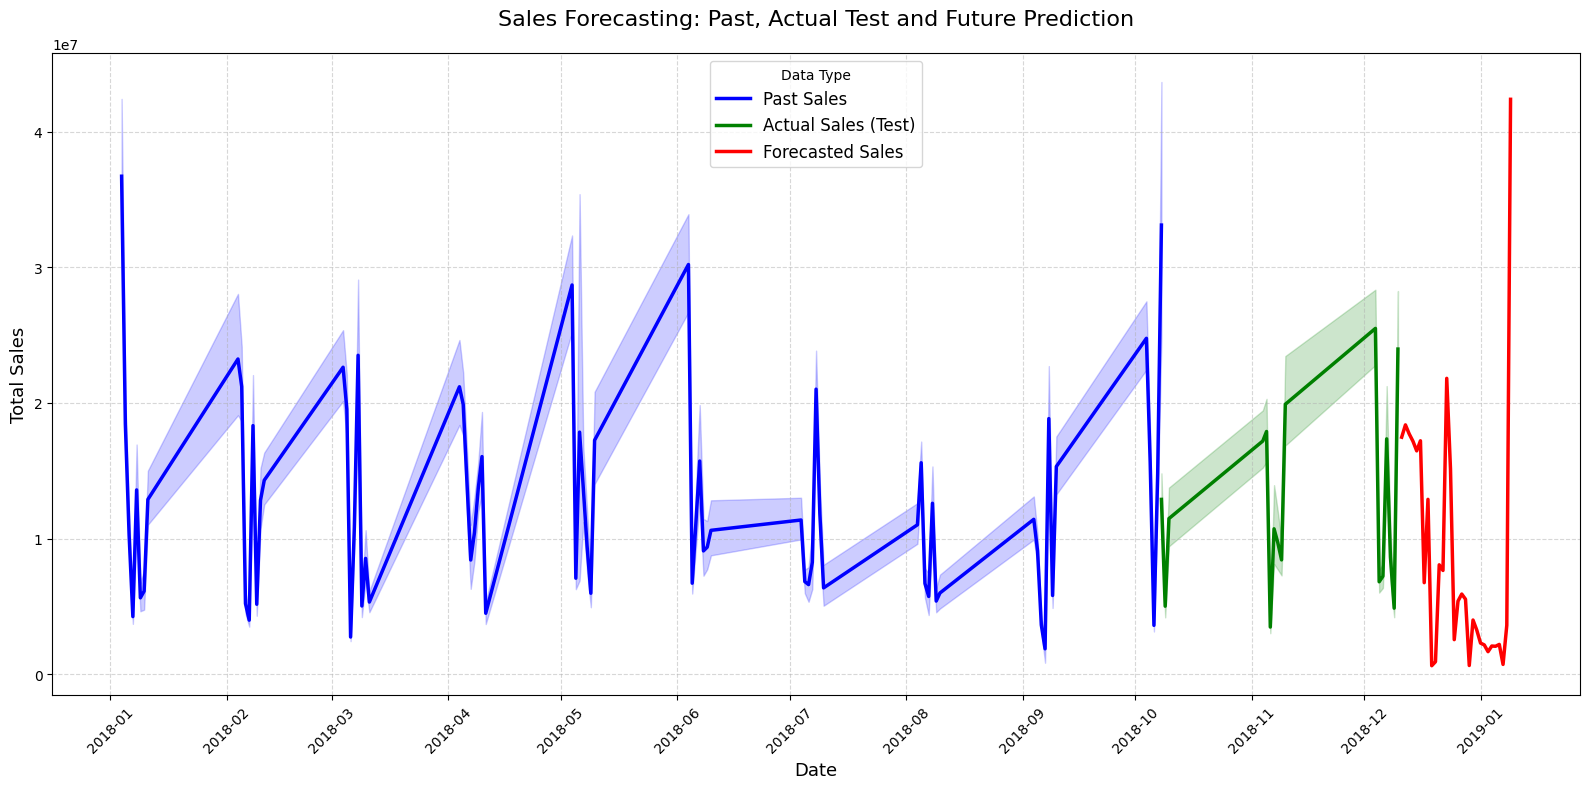

,Date,Predicted Sales
0,2018-12-11,1.747774e+07
1,2018-12-12,1.838556e+07
2,2018-12-13,1.772090e+07
3,2018-12-14,1.718211e+07
4,2018-12-15,1.646990e+07
5,2018-12-16,1.721420e+07
6,2018-12-17,6.750472e+06
7,2018-12-18,1.289398e+07
8,2018-12-19,6.263469e+05
9,2018-12-20,9.194649e+05


In [10]:
import matplotlib.dates as mdates
import seaborn as sns
from datetime import timedelta
import pandas as pd

# Lấy ngày cuối cùng từ test_df
last_date = test_df['date'].iloc[-1]

# Tạo danh sách 30 ngày tiếp theo từ ngày cuối cùng
future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=30).strftime('%Y-%m-%d')

# Chuẩn bị dữ liệu đầu vào cho dự đoán
future_X_raw = test_df[features].iloc[-30:].values
future_X_scaled = scaler_X.transform(future_X_raw)

# Dự đoán doanh thu cho 30 ngày tiếp theo
model.eval()
with torch.no_grad():
    future_X_tensor = torch.tensor(future_X_scaled, dtype=torch.float32).to(device)
    future_preds_scaled = model(future_X_tensor).cpu().numpy().flatten()
    future_sales = scaler_y.inverse_transform(future_preds_scaled.reshape(-1, 1)).flatten()

# Tạo DataFrame chứa dự đoán
future_df = pd.DataFrame({
    'date': future_dates,
    'total_sales': future_sales,
    'type': 'Forecasted Sales'
})

# Chuẩn bị dữ liệu quá khứ để visualization
train_df['type'] = 'Past Sales'
valid_df['type'] = 'Past Sales'
test_df['type'] = 'Actual Sales (Test)'  # Thêm thông tin cho test data

# Gộp tất cả dữ liệu
combined_df = pd.concat([train_df, valid_df, test_df, future_df], ignore_index=True)

# Vẽ đồ thị
plt.figure(figsize=(16, 8))
sns.lineplot(
    data=combined_df,
    x='date',
    y='total_sales',
    hue='type',
    style='type',
    dashes=False,
    palette={
        'Past Sales': 'blue',
        'Actual Sales (Test)': 'green',
        'Forecasted Sales': 'red'
    },
    linewidth=2.5
)

# Định dạng trục x
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)

# Thêm các chi tiết cho đồ thị
plt.xlabel('Date', fontsize=13)
plt.ylabel('Total Sales', fontsize=13)
plt.title('Sales Forecasting: Past, Actual Test and Future Prediction', fontsize=16, pad=20)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title='Data Type', fontsize=12)
plt.tight_layout()
plt.show()

# Trả về dataframe chứa dự đoán
future_df[['date', 'total_sales']].rename(columns={'date': 'Date', 'total_sales': 'Predicted Sales'})
